### Study of effect of national factors on home prices in US

**Task -** Using publically available data for the national factors that impact supply and demand of homes in US, build a model to study the effect of these variables on home prices.

**Approach -** The following variables are chosen for the study-
- Per Capita GDP
- Unemployment Rate
- Household Income
- Construction Prices 
- CPI
- Interest Rates
- Housing subsidies
- Number of new houses supplied
- Number of Households

As a proxy to the home prices, S&P CASE-SHILLER Index is used. 

Most of the data is downloaded from [https://fred.stlouisfed.org/] with date range of 1st Jan 2000 to 11 Dec 2023 .

**Source**
CASE-SCHILLER Home Price Index - https://fred.stlouisfed.org/series/CSUSHPISA

Interest rates - https://fred.stlouisfed.org/series/FEDFUNDS

Unemployment rate - https://fred.stlouisfed.org/series/UNRATE

Income - https://fred.stlouisfed.org/series/DSPIC96

Per Capita GDP - https://fred.stlouisfed.org/series/A939RX0Q048SBEA

New Houses - https://fred.stlouisfed.org/series/COMPUTSA

Construction price index - https://fred.stlouisfed.org/series/WPUSI012011

Housing Subsidies (Federal) - https://fred.stlouisfed.org/series/L312051A027NBEA

Total households - https://fred.stlouisfed.org/series/TTLHH

Data for all the variables is downloaded, preprocessed and combined to create a datset. Data for different variables had different frequencies. So, to combine the data, necessary interpolations are made.

Linear Regression is used as most of the variables have high correlation with the target variable.

In [1]:
# importing libraries
import numpy as np
import pandas as pd

In [2]:
#Reading CASE-SHILLER Index into a dataframe
df_CS = pd.read_csv("CSUSHPISA.csv")

#Changing dtype of date column
df_CS["DATE"] = pd.to_datetime(df_CS["DATE"])

#Selecting data post JUNE 2001
mask = df_CS["DATE"] >= "2001-07-01"
df_CS = df_CS[mask]

#Resetting Index
df_CS.reset_index(inplace = True)
df_CS.drop(columns = ["index"], inplace = True)

# Creating "Year" and "Month" columns
df_CS["Year"] = pd.DatetimeIndex(df_CS["DATE"]).year
df_CS["Month"] = pd.DatetimeIndex(df_CS["DATE"]).month
print(df_CS.shape)
df_CS.tail()

(267, 4)


,DATE,CSUSHPISA,Year,Month
262,2023-05-01,302.566,2023,5
263,2023-06-01,304.593,2023,6
264,2023-07-01,306.767,2023,7
265,2023-08-01,309.155,2023,8
266,2023-09-01,311.175,2023,9


In [3]:
# Reading Unemployment Rate Data into a dataframe
df_unemp = pd.read_csv("UNRATE.csv")
df_unemp.drop([252,253], inplace = True)
print(df_unemp.shape)
df_unemp.head()

(285, 2)


,DATE,UNRATE
0,2000-01-01,4.0
1,2000-02-01,4.1
2,2000-03-01,4.0
3,2000-04-01,3.8
4,2000-05-01,4.0


In [4]:
# Reading Per Capita GDP Data into a dataframe
df_pcgdp = pd.read_csv("PC_GDP.csv", names = ["DATE", "Per_Capita_GDP"], skiprows = 1)
print(df_pcgdp.shape)
df_pcgdp.head()

(95, 2)


,DATE,Per_Capita_GDP
0,2000-01-01,49335.0
1,2000-04-01,50109.0
2,2000-07-01,50024.0
3,2000-10-01,50190.0
4,2001-01-01,49911.0


The data is quarterly. We will impute for other months using linear interpolation after we create the final dataframe combining all the data.

In [5]:
# Interest Rate Data
df_Fed_rate = pd.read_csv("Interest rates.csv").drop([252,253])
print(df_Fed_rate.shape)
df_Fed_rate.head()

(285, 2)


,DATE,FEDFUNDS
0,2000-01-01,5.45
1,2000-02-01,5.73
2,2000-03-01,5.85
3,2000-04-01,6.02
4,2000-05-01,6.27


In [6]:
# Reading Construction Price into a dataframe
df_cons_price_index = pd.read_csv("Construction_Price.csv", names = ["DATE", "Cons_Materials"], skiprows = 1)
df_cons_price_index.drop([252], inplace = True)
print(df_cons_price_index.shape)
df_cons_price_index.head()

(286, 2)


,DATE,Cons_Materials
0,2000-01-01,144.1
1,2000-02-01,144.7
2,2000-03-01,145.4
3,2000-04-01,145.6
4,2000-05-01,144.9


In [7]:
# Consumer Price Index
df_CPI = pd.read_csv("CPI.csv", names = ["DATE", "CPI"], skiprows = 1).drop([252])
print(df_CPI.shape)
df_CPI.head()

(286, 2)


,DATE,CPI
0,2000-01-01,144.1
1,2000-02-01,144.7
2,2000-03-01,145.4
3,2000-04-01,145.6
4,2000-05-01,144.9


In [8]:
# Housing Subsidies

df_subsidy = pd.read_csv("Subsidies.csv", names = ["DATE", "Subsidy"], skiprows = 1)
print(df_subsidy.shape)
df_subsidy.head()

(23, 2)


,DATE,Subsidy
0,2000-01-01,19.690
1,2001-01-01,20.573
2,2002-01-01,24.183
3,2003-01-01,25.930
4,2004-01-01,27.201


In [9]:
# New house numbers
df_house = pd.read_csv("New_houses.csv", names = ["DATE", "Houses"], skiprows = 1).drop([252])
print(df_house.shape)
df_house.head()

(285, 2)


,DATE,Houses
0,2000-01-01,1574.0
1,2000-02-01,1677.0
2,2000-03-01,1704.0
3,2000-04-01,1610.0
4,2000-05-01,1682.0


In [10]:
# Household Income

df_income = pd.read_csv("income.csv", names = ["DATE", "Income"], skiprows = 1)
print(df_income.shape)
df_income.head()

(286, 2)


,DATE,Income
0,2000-01-01,9799.9
1,2000-02-01,9837.9
2,2000-03-01,9864.0
3,2000-04-01,9913.7
4,2000-05-01,9954.5


In [11]:
# Number of households

df_households = pd.read_csv("Households.csv", names = ["DATE", "Num_Households"], skiprows = 1)
print(df_households.shape)
df_households.head()

(24, 2)


,DATE,Num_Households
0,2000-01-01,104705.0
1,2001-01-01,108209.0
2,2002-01-01,109297.0
3,2003-01-01,111278.0
4,2004-01-01,112000.0


In [12]:
# Merging Per Capita GDP (Quarterly data)
df_pcgdp["DATE"] = pd.to_datetime(df_pcgdp["DATE"])
df_CS = pd.merge(df_CS,df_pcgdp, how = "left")
df_CS.head()

,DATE,CSUSHPISA,Year,Month,Per_Capita_GDP
0,2001-07-01,113.491,2001,7,49774.0
1,2001-08-01,114.167,2001,8,NaN
2,2001-09-01,114.812,2001,9,NaN
3,2001-10-01,115.310,2001,10,49783.0
4,2001-11-01,115.857,2001,11,NaN


In [13]:
df = pd.DataFrame()
df_bymonth = [df_CS, df_house, df_CPI, df_unemp, df_cons_price_index, df_Fed_rate]
for df1 in df_bymonth:
    df1["DATE"] = pd.to_datetime(df1["DATE"])
    df1 = df1.set_index("DATE")
    df = pd.concat([df,df1], axis = 1)
print(df.shape)
df.head()

(287, 9)


,CSUSHPISA,Year,Month,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS
DATE,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,1574.0,144.1,4.0,144.1,5.45
2000-02-01,NaN,NaN,NaN,NaN,1677.0,144.7,4.1,144.7,5.73
2000-03-01,NaN,NaN,NaN,NaN,1704.0,145.4,4.0,145.4,5.85
2000-04-01,NaN,NaN,NaN,NaN,1610.0,145.6,3.8,145.6,6.02
2000-05-01,NaN,NaN,NaN,NaN,1682.0,144.9,4.0,144.9,6.27


In [14]:
# Merging other dataframes 
others = [df_income, df_subsidy]
for df1 in others:
    if "Year" not in df1.columns:
        df1["Year"] = pd.DatetimeIndex(df1["DATE"]).year
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
    else:
        df1.set_index("DATE", inplace = True)
        df = pd.merge(df, df1, how = "left", on = "Year")
df["DATE"] = df_CS["DATE"]
df.set_index("DATE", inplace = True)
df.head()

,CSUSHPISA,Year,Month,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Income,Subsidy
DATE,,,,,,,,,,,
2001-07-01,NaN,NaN,NaN,NaN,1574.0,144.1,4.0,144.1,5.45,NaN,NaN
2001-08-01,NaN,NaN,NaN,NaN,1677.0,144.7,4.1,144.7,5.73,NaN,NaN
2001-09-01,NaN,NaN,NaN,NaN,1704.0,145.4,4.0,145.4,5.85,NaN,NaN
2001-10-01,NaN,NaN,NaN,NaN,1610.0,145.6,3.8,145.6,6.02,NaN,NaN
2001-11-01,NaN,NaN,NaN,NaN,1682.0,144.9,4.0,144.9,6.27,NaN,NaN


In [15]:
df.isna().sum()

CSUSHPISA           20
Year                20
Month               20
Per_Capita_GDP    2144
Houses              13
CPI                 12
UNRATE              24
Cons_Materials      12
FEDFUNDS            24
Income              20
Subsidy            110
dtype: int64

### The "Per_Capita_GDP" column has missing values because the data was quarterly. The missing values in the other columns is due to unavailability of fresh data. We will first fill the missing values in the "Per_Capita_GDP" column using linear interpolation. We will drop the rows having missing values in the other columns. This means that we will use data from 2003 to 2023

In [16]:
# Filling missing values in the Per_Capita_GDP column using linear interpolation
df["Per_Capita_GDP"] = df["Per_Capita_GDP"].interpolate()

In [17]:
df.head()

,CSUSHPISA,Year,Month,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Income,Subsidy
DATE,,,,,,,,,,,
2001-07-01,NaN,NaN,NaN,NaN,1574.0,144.1,4.0,144.1,5.45,NaN,NaN
2001-08-01,NaN,NaN,NaN,NaN,1677.0,144.7,4.1,144.7,5.73,NaN,NaN
2001-09-01,NaN,NaN,NaN,NaN,1704.0,145.4,4.0,145.4,5.85,NaN,NaN
2001-10-01,NaN,NaN,NaN,NaN,1610.0,145.6,3.8,145.6,6.02,NaN,NaN
2001-11-01,NaN,NaN,NaN,NaN,1682.0,144.9,4.0,144.9,6.27,NaN,NaN


In [18]:
df.dropna(inplace = True)

In [19]:
df.isna().sum()

CSUSHPISA         0
Year              0
Month             0
Per_Capita_GDP    0
Houses            0
CPI               0
UNRATE            0
Cons_Materials    0
FEDFUNDS          0
Income            0
Subsidy           0
dtype: int64

In [20]:
df.shape

(3072, 11)

In [21]:
df.head()

,CSUSHPISA,Year,Month,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Income,Subsidy
DATE,,,,,,,,,,,
2003-01-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10211.7,20.573
2003-02-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10223.4,20.573
2003-03-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10254.4,20.573
2003-04-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10233.1,20.573
2003-05-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10214.7,20.573


This is our preprocessed datset. Let's save it as "prepared_dataset.csv".

In [22]:
df.to_csv("prepared_dataset.csv")

In [41]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

In [24]:
# Reading prepared data into a dataframe.
df = pd.read_csv("prepared_dataset.csv").set_index("DATE")
df.head()

,CSUSHPISA,Year,Month,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Income,Subsidy
DATE,,,,,,,,,,,
2003-01-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10211.7,20.573
2003-02-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10223.4,20.573
2003-03-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10254.4,20.573
2003-04-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10233.1,20.573
2003-05-01,113.491,2001.0,7.0,49774.0,1582.0,143.4,4.6,143.4,3.77,10214.7,20.573


We don't need the month and year columns for our analysis. So, let's drop these colums.

In [25]:
# Dropping year and month columns
df.drop(columns = ["Year", "Month"], inplace = True)

# Analysis

Let's look at the correlation among the variables.

In [26]:
# Correlation
df.corr()

,CSUSHPISA,Per_Capita_GDP,Houses,CPI,UNRATE,Cons_Materials,FEDFUNDS,Income,Subsidy
CSUSHPISA,1.000000,0.907036,0.146628,0.903065,-0.453952,0.903065,0.087435,0.818643,0.849085
Per_Capita_GDP,0.907036,1.000000,-0.144738,0.920820,-0.403012,0.920820,-0.128727,0.943166,0.933425
Houses,0.146628,-0.144738,1.000000,-0.240813,-0.555236,-0.240813,0.685626,-0.272892,-0.321866
CPI,0.903065,0.920820,-0.240813,1.000000,-0.229463,1.000000,-0.243428,0.884011,0.936728
UNRATE,-0.453952,-0.403012,-0.555236,-0.229463,1.000000,-0.229463,-0.517965,-0.189551,-0.113223
Cons_Materials,0.903065,0.920820,-0.240813,1.000000,-0.229463,1.000000,-0.243428,0.884011,0.936728
FEDFUNDS,0.087435,-0.128727,0.685626,-0.243428,-0.517965,-0.243428,1.000000,-0.304208,-0.335430
Income,0.818643,0.943166,-0.272892,0.884011,-0.189551,0.884011,-0.304208,1.000000,0.958252
Subsidy,0.849085,0.933425,-0.321866,0.936728,-0.113223,0.936728,-0.335430,0.958252,1.000000


In [27]:
# Separating the target variable and the independent variable
y = df.pop("CSUSHPISA")
X = df

0 Per_Capita_GDP
1 Houses
2 CPI
3 UNRATE
4 Cons_Materials
5 FEDFUNDS
6 Income
7 Subsidy


C:\Users\tusha\AppData\Local\Temp\ipykernel_6516\3779739366.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,2,i+1) #3 - no.of rows 2--> no.of columns


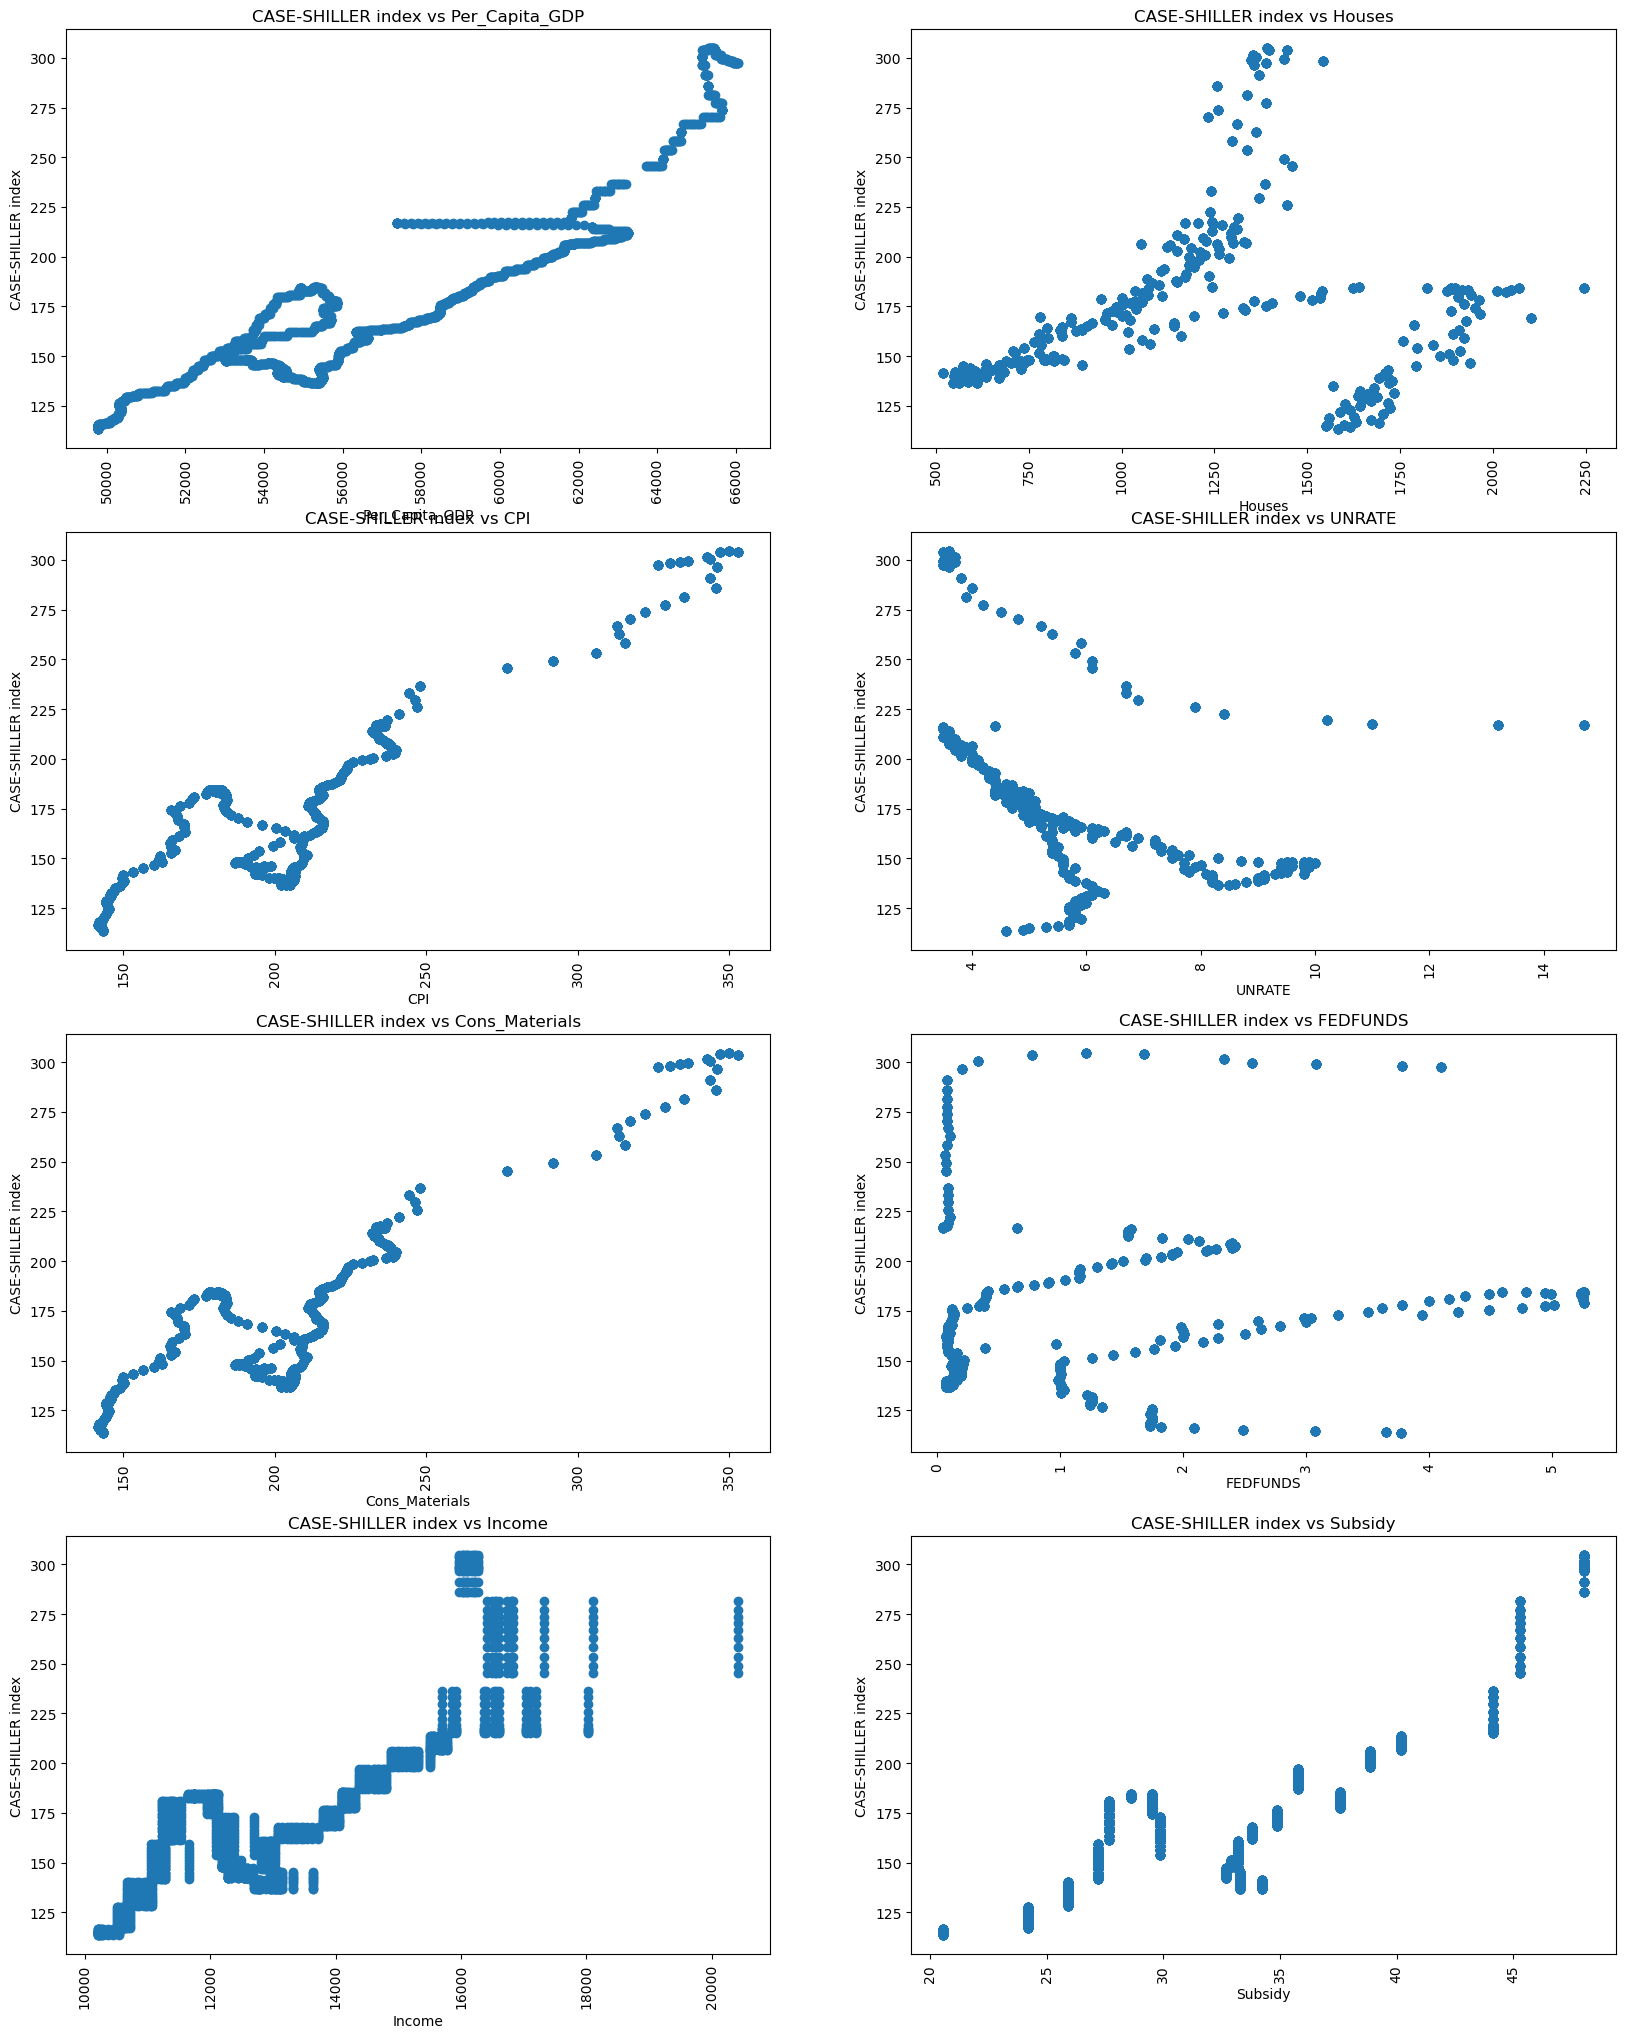

In [28]:
# Plotting scatter plots of the CASE-SHILLER index vs features

fig = plt.subplots(figsize=(20,25))
#for i in range(a):
for i,feature in enumerate(X.columns): #supports more than one traversing variable
    print(i,feature)
    #i --> Index values
    #Feature --> data
    plt.subplot(4,2,i+1) #3 - no.of rows 2--> no.of columns
    #(4,2,1), (4,2,2).....
    plt.scatter(x=X[feature], y = y)
    plt.xlabel(feature)
    plt.ylabel("CASE-SHILLER index")
    plt.title(f"CASE-SHILLER index vs {feature}")
    plt.xticks(rotation=90)#helps in the rotation of the x- values
plt.show()

From the correlation matrix and the scatter plots, the following conclusions can be made-

-Unemployment rate is negatively correlated with the home prices. Which makes sense.
-Number of new houses has almost 0 correlation. This is unexpected as one would think that the number of houses supplied should   also affect home prices. Maybe the number of new houses built are not enough to bring the prices down significantly.
-Impact of the great recession is reflected in almost all the plots.
-Interest rates have a slight negative impact on the home prices.
-All the other variables are positively correlated with the home prices.

From the correlation matrix above, it can be seen that several pairs of independent variables have high correlation. Let's drop one column from each such pair as they will cause multicollinearity. We will drop the column which has lower correlation with the target.

In [29]:
# Dropping multicollinearity columns
mult_cols = ["CPI", "Subsidy", "Cons_Materials", "Income"]
df.drop(columns = mult_cols, inplace = True)
X = df

In [30]:
X

,Per_Capita_GDP,Houses,UNRATE,FEDFUNDS
DATE,,,,
2003-01-01,49774.0,1582.0,4.6,3.77
2003-02-01,49774.0,1582.0,4.6,3.77
2003-03-01,49774.0,1582.0,4.6,3.77
2003-04-01,49774.0,1582.0,4.6,3.77
2003-05-01,49774.0,1582.0,4.6,3.77
...,...,...,...,...
NaN,66019.0,1390.0,3.5,4.10
NaN,66030.8,1390.0,3.5,4.10
NaN,66042.6,1390.0,3.5,4.10


# Model Building

In [31]:
# Scaling
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

In [37]:
# Splitting data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.6, random_state= 42)

In [38]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = r2_score(pred, y_test)
print("The r2_score for the validation set is: ", score)

The r2_score for the validation set is:  0.9178164306446845


The r2 score is close to 1. It means that the model predicts the target variable with good accuracy.

In [34]:
#Printing the regression coefficients of different variables
coefs = model.coef_
cols = df.columns
for i in range(len(coefs)):
    print(f"The coefficient for {cols[i]} is {coefs[i]}")

The coefficient for Per_Capita_GDP is 173.46528876846256
The coefficient for Houses is 63.45568879108005
The coefficient for UNRATE is 53.92896911839761
The coefficient for FEDFUNDS is 11.330758412133008


In [35]:
# The intercept
print("The intercept is: ", model.intercept_)


The intercept is:  59.972348196285395


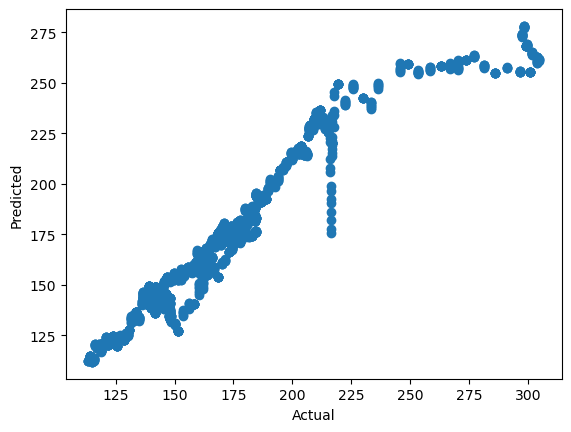

In [39]:
plt.scatter(y_test,pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

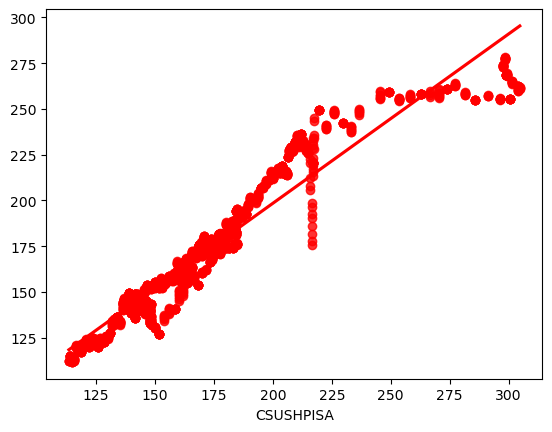

In [42]:
sns.regplot(x=y_test,y=pred,ci=None,color ='red');